In [332]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import finufft
import time
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential
import math
from torch.profiler import profile, record_function, ProfilerActivity
import pytorch_finufft.functional as pff
from efgp1d import efgp1d, efgp1d_NUFFT, efgp1d_gradient_batched
from efgp_1d_dense import efgp1d_dense


import warnings
warnings.filterwarnings("ignore", message=".*disabling cuda.*")


In [333]:


# --- Parameters ---
n = 1000  # Number of points
d = 2     # Dimensionality of the input space
true_length_scale = .3
true_variance = 0.1
true_noise_variance = 0.1
dtype = torch.float64  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")

# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1

# Generate test points (grid of points for visualization if d <= 3)
if d <= 3:
    # Create a grid of points for testing
    grid_points_per_dim = 10
    grid_points = [torch.linspace(-1.2, 1.2, grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

# --- Define Mean and Covariance Functions (using PyTorch) ---
def mean_func_torch(x):
    """Mean function (returns zero vector)."""
    # Make sure output shape matches input batch shape if any
    return torch.zeros(x.shape[0], dtype=x.dtype, device=x.device)

# Squared Exponential Kernel Function for d-dimensional inputs
def squared_exponential_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """
    Squared Exponential kernel using PyTorch.
    Calculates variance * exp(-0.5 * ||x1 - x2||^2 / length_scale^2)
    Handles multi-dimensional (n, d) inputs.
    """
    # Compute pairwise squared Euclidean distances
    # dist_sq = ||a - b||^2 = ||a||^2 - 2a^T b + ||b||^2
    sum_sq_x1 = torch.sum(x1**2, dim=1, keepdim=True)  # Shape (n, 1)
    sum_sq_x2 = torch.sum(x2**2, dim=1)                # Shape (m,)
    cross_term = torch.matmul(x1, x2.T)                # Shape (n, m)

    # sq_dist shape: (n, 1) + (m,) - 2 * (n, m) -> broadcasting -> (n, m)
    sq_dist = sum_sq_x1 + sum_sq_x2 - 2 * cross_term

    # Ensure squared distances are non-negative (due to potential floating point inaccuracies)
    sq_dist = torch.clamp(sq_dist, min=0.0)

    # Compute the Squared Exponential kernel
    cov = variance * torch.exp(-0.5 * sq_dist / length_scale**2)
    return cov

# --- Optimized Sampling Function ---
def sample_gp_fast(x, mean_func, cov_func, num_samples, length_scale, variance, noise_variance):
    """
    Samples efficiently from a d-dimensional Gaussian Process by pre-computing
    the Cholesky decomposition of the noisy covariance matrix.

    Parameters:
    x : torch.Tensor (n, d)
        Input points in d-dimensional space.
    mean_func : callable
        Mean function.
    cov_func : callable
        Covariance function (kernel).
    num_samples : int
        Number of samples to draw.
    length_scale : float
        Kernel length scale.
    variance : float
        Kernel variance.
    noise_variance : float
        Variance of the observation noise.

    Returns:
    torch.Tensor (n, num_samples)
        Samples from the GP at the input points x.
    """
    n_points = x.shape[0]
    mean = mean_func(x)  # Shape (n_points,)

    # 1. Compute Covariance Matrix K
    K = cov_func(x, x, length_scale=length_scale, variance=variance)  # (n_points, n_points)

    # 2. Add Noise Variance to Diagonal
    K_noisy = K + noise_variance * torch.eye(n_points, dtype=x.dtype, device=x.device)

    # 3. Compute Cholesky Factor L (K_noisy = L L^T)
    try:
        L = torch.linalg.cholesky(K_noisy)  # (n_points, n_points), lower triangular
    except torch.linalg.LinAlgError as e:
        print(f"Cholesky decomposition failed: {e}")
        # Fallback with jitter
        jitter = 1e-6 * torch.eye(n_points, dtype=x.dtype, device=x.device)
        try:
            L = torch.linalg.cholesky(K_noisy + jitter)
            print("Cholesky succeeded after adding jitter.")
        except torch.linalg.LinAlgError as e2:
            print(f"Cholesky decomposition failed even with jitter: {e2}")
            raise RuntimeError("Could not compute Cholesky decomposition.") from e2

    # 4. Efficient Sampling
    # Draw standard normal samples Z ~ N(0, I)
    Z = torch.randn(n_points, num_samples, dtype=x.dtype, device=x.device)  # (n_points, num_samples)

    # Compute samples: Y = mean + L @ Z
    samples = mean.unsqueeze(1) + L @ Z  # (n_points, num_samples)

    return samples

# --- Generate Samples ---
print(f"Generating {1} sample for n={n} points in {d} dimensions...")
start_time = time.time()

# Sample using the optimized function
y = sample_gp_fast(
    x,
    mean_func_torch,
    squared_exponential_kernel,
    num_samples=1,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
).flatten()

end_time = time.time()
print(f"Generated sample of size {y.shape[0]}.")
print(f"Time taken: {end_time - start_time:.4f} seconds")


Using device: cpu
Generating 1 sample for n=1000 points in 2 dimensions...
Generated sample of size 1000.
Time taken: 0.0168 seconds


Plotting the generated Gaussian Process data...


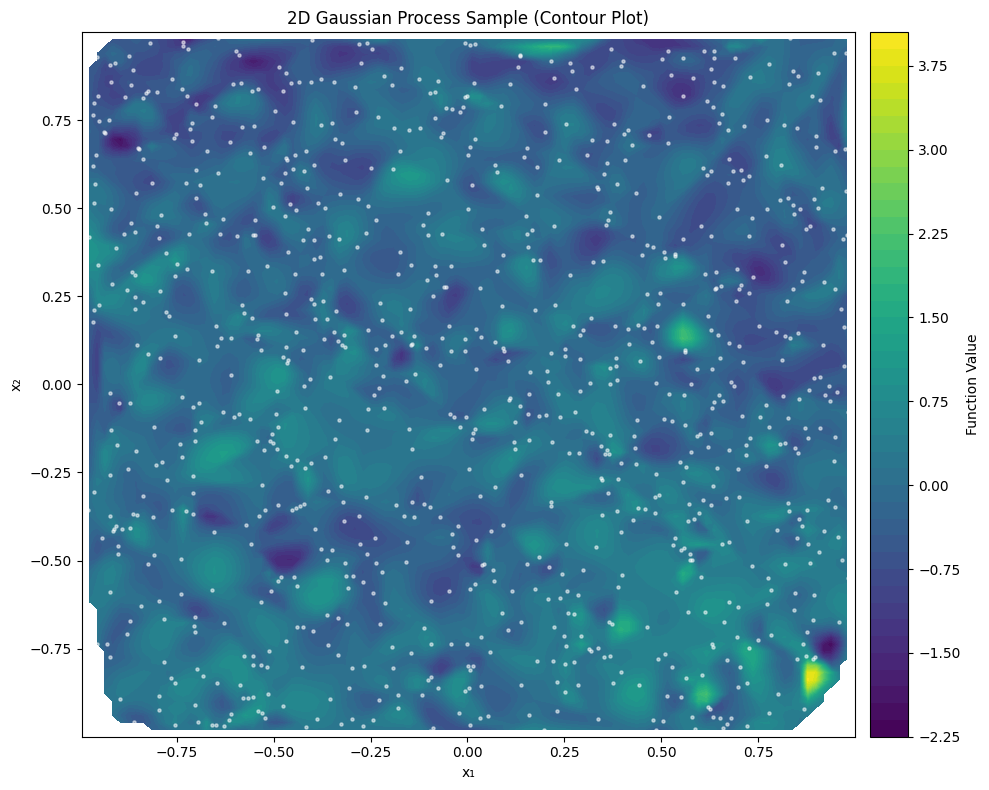

In [334]:
# --- Plot the Generated Data ---
print("Plotting the generated Gaussian Process data...")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

# Determine the dimensionality of the data
d = x.shape[1]

if d == 1:
    # 1D plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x.cpu().numpy(), y.cpu().numpy(), alpha=0.7, s=10)
    plt.title('1D Gaussian Process Sample')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

elif d == 2:
    # 2D contour plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [1, 0.05]})
    
    # Extract coordinates
    x1, x2 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create a regular grid for interpolation
    grid_size = 100
    x1_grid = np.linspace(x1.min(), x1.max(), grid_size)
    x2_grid = np.linspace(x2.min(), x2.max(), grid_size)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    
    # Interpolate the scattered data onto the regular grid
    Y_grid = griddata((x1, x2), y_values, (X1, X2), method='cubic')
    
    # Create contour plot
    contour = ax[0].contourf(X1, X2, Y_grid, 50, cmap='viridis')
    ax[0].scatter(x1, x2, c='white', s=5, alpha=0.5)
    ax[0].set_title('2D Gaussian Process Sample (Contour Plot)')
    ax[0].set_xlabel('x₁')
    ax[0].set_ylabel('x₂')
    
    # Add colorbar
    plt.colorbar(contour, cax=ax[1], label='Function Value')
    
    plt.tight_layout()
    plt.show()

elif d == 3:
    # 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract coordinates
    x1, x2, x3 = x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), x[:, 2].cpu().numpy()
    y_values = y.cpu().numpy()
    
    # Create scatter plot with color representing the function value
    scatter = ax.scatter(
        x1, x2, x3, 
        c=y_values, 
        cmap='viridis', 
        s=30, 
        alpha=0.8
    )
    
    plt.colorbar(scatter, ax=ax, label='Function Value')
    ax.set_title('3D Gaussian Process Sample')
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_zlabel('x₃')
    plt.tight_layout()
    plt.show()

else:
    print(f"Cannot visualize data in {d} dimensions directly.")
    
    # For higher dimensions, we can show pairwise relationships
    if d > 3:
        print("Showing pairwise relationships for the first 3 dimensions:")
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot first 3 dimensions against the function value
        for i in range(min(3, d)):
            scatter = axs[i].scatter(
                x[:, i].cpu().numpy(), 
                y.cpu().numpy(), 
                alpha=0.7, 
                s=10, 
                c=y.cpu().numpy(), 
                cmap='viridis'
            )
            axs[i].set_xlabel(f'x_{i+1}')
            axs[i].set_ylabel('Function Value')
            axs[i].grid(True)
            
        plt.colorbar(scatter, ax=axs)
        plt.tight_layout()
        plt.show()


In [335]:

kernel = SquaredExponential(dimension=d, lengthscale=torch.tensor([true_length_scale]), variance=torch.tensor(true_variance))
init_kernel = kernel
# kernel = SquaredExponential(dimension=1, lengthscale=torch.tensor([0.5*1e-2]), variance=torch.tensor(1.0))


In [336]:
kernel

SquaredExponential(dimension=2, lengthscale=0.30000001192092896, variance=0.10000000149011612)

# Making tensor product grid of xis 

In [337]:
# Determine problem geometry
# max and min of each dimension
x0 = x.min(dim=0).values  
x1 = x.max(dim=0).values  

domain_lengths = x1 - x0
L = domain_lengths.max()
N = x.shape[0]
EPSILON = 1e-6
xis_1d, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)
print(xis_1d.shape)
grids = torch.meshgrid(*(xis_1d for _ in range(d)), indexing='ij') # makes tensor product Jm 
xis = torch.stack(grids, dim=-1).view(-1, d) 
print(xis.shape)
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h**d) # (mtot**d,1)


torch.Size([25])
torch.Size([625, 2])


In [338]:
D = torch.diag(ws).to(dtype=torch.complex128) # (mtot**d, mtot**d)


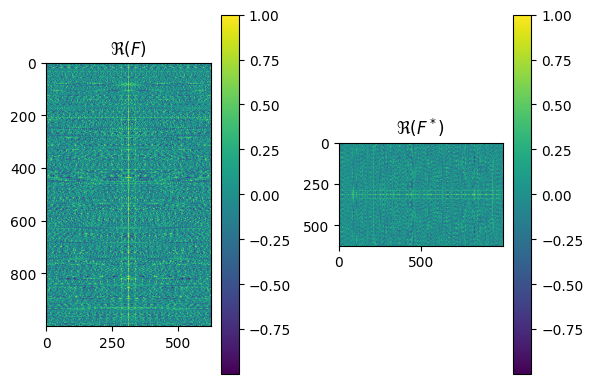

In [339]:

# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT) x @ j.t()  
F = torch.exp(1j * 2 * torch.pi * (x @ xis.T))
# F = torch.exp(1j * 2 * torch.pi * (x@xis.t()).to(dtype=torch.complex128))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(F.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F)$')

im2 = ax2.imshow(F.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(F^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag



In [340]:
# get kernel matrix using kernel.kernel_matrix
kernel_matrix = kernel.kernel_matrix(x, x)


In [341]:
ws = ws.to(dtype=torch.complex128)
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))

Kernel matrix and kernel approx are close at 1e-06


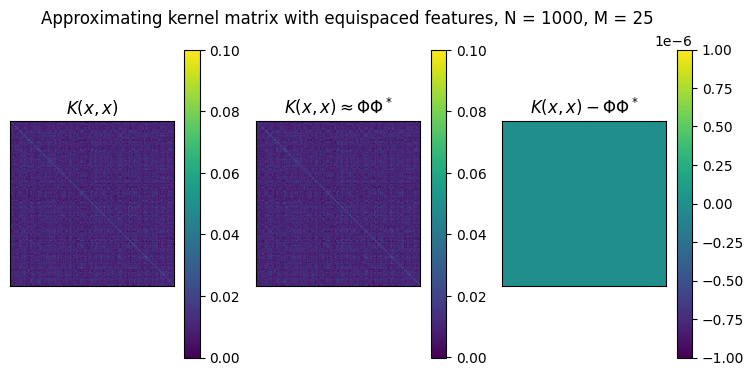

In [342]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')
# Get the maximum absolute value in the difference matrix for colorbar limits
# Set the color limits to be symmetric around zero, bounded by epsilon
im3.set_clim(-EPSILON, EPSILON)

assert torch.allclose(kernel_matrix, kernel_approx.real, atol=EPSILON)
print(f"Kernel matrix and kernel approx are close at {EPSILON}")



In [343]:
import math
import torch
import pytorch_finufft.functional as pff

# ─────────── Inputs (already defined) ────────────────────────────────────
# x      : torch.Tensor of shape (N, d)   — real training locations
# y      : torch.Tensor of shape (N,)     — real training targets
# kernel : object with kernel.spectral_density(xis) method
# EPSILON: float, quadrature tolerance
# ────────────────────────────────────────────────────────────────────────

device = x.device
rdtype = torch.float64
cdtype = torch.complex128
OUT    = (mtot,) * d                     # NUFFT output shape

# 1) Cast to double and move to device
x = x.to(device, rdtype)
y = y.to(device, rdtype)

N, d = x.shape

# 2) Single‐dimensional quadrature (shared across dims)
#    Use the maximal span among the d coordinates
span   = (x.max(dim=0).values - x.min(dim=0).values).max().item()

xcen = torch.zeros(d, device=device, dtype=rdtype)
phi  = 2 * math.pi * h * (x - xcen)     # (N, d)
phi  = phi.T.contiguous()               # (d, N) for finufft

# 5) NUFFT wrappers (torch‑native, CMCL order)
nufft_eps = 1e-15

def finufft1(vals):
    """
    Adjoint NUFFT: nonuniform→uniform.
    vals: (N,) complex
    returns: tensor of shape OUT, then flattened
    """
    arr = pff.finufft_type1(
        phi, vals.to(cdtype), OUT,
        eps=nufft_eps, isign=-1, modeord=False
    )
    return arr.reshape(-1)  # (mtot**d,)

def finufft2(fk_flat):
    """
    Forward NUFFT: uniform→nonuniform.
    fk_flat: (mtot**d,) complex, in CMCL order
    returns: tensor of shape (N,)
    """
    fk_nd = fk_flat.reshape(OUT)
    return pff.finufft_type2(
        phi, fk_nd.to(cdtype),
        eps=nufft_eps, isign=+1, modeord=False
    )

# 6) Sanity checks:

# (a)  F* y  via NUFFT
fadj_y_nufft = finufft1(y)
fadj_y_nufft_ref = F.conj().T@y.to(dtype=torch.complex128)

# (b)  F  ws_nd  via NUFFT
f_ws_nufft  = finufft2(ws)

f_ws_nufft_ref = F@ws

torch.allclose(fadj_y_nufft, fadj_y_nufft_ref)
torch.allclose(f_ws_nufft, f_ws_nufft_ref)
print(f"Multi‑D NUFFT adjoint/forward check passed for OUT={OUT}")


✅ Multi‑D NUFFT adjoint/forward check passed for OUT=(25, 25)
